# Сегментация пользователей по потреблению в банке

Описание проекта

Требуется проанализировать данные о клиентах регионального банка и сегментировать пользователей, чтобы сформулировать рекомендации по удержанию клиентов и стимулированию к покупке продуктов банка.

Заказчик — менеджер продукта банка. 

Цель исследования — сегментировать пользователей, определить, какие факторы влияют на количество используемых продуктов, факт оттока. 

**Презентация:**

https://drive.google.com/file/d/1wYKWLcj2bQ-3UfivpdpnSez8sR3ECcFT/view?usp=sharing

**Дашборд:**

Дашборд отображает распределение заработной платы клиентов.
Цветом показан процент клиентов, имеющих кредитную карту.
Фильтр дашборда позволяет сделать выборку по ушедшим и оставшимся клиентам.

https://public.tableau.com/views/Segmentationofbankusers/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link

## Загрузка и предобработка данных

In [1]:
#Загрузим библиотеки, которые понадобятся
import pandas as pd
import numpy as np
import math as mth
import matplotlib.pyplot as plt 
import matplotlib as mpl 
import plotly.express as px
from plotly import graph_objects as go
import seaborn as sns 
from numpy import median
from scipy import stats as st


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier


import warnings
warnings.filterwarnings('ignore')

In [2]:
# Настройки для графиков
sns.set(font_scale=1.3)
sns.set_style('whitegrid',
              {'figure.facecolor': '0.95',
               'figure.facecolor': 'white',
               'font.family': ['Liberation Serif']})

plt.rcParams["font.family"] = "Liberation Serif", "Garamond", "serif"

In [3]:
# Прочитаем файл bank_dataset и сохраним его
try:
    bank_dataset = pd.read_csv('/datasets/bank_dataset.csv', sep=',')
except:
    bank_dataset = pd.read_csv('bank_dataset.csv', sep=',')
bank_dataset.head(10)

,userid,score,City,Gender,Age,Objects,Balance,Products,CreditCard,Loyalty,estimated_salary,Churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0
5,15616748,645,Рыбинск,М,44,8,113755.78,2,1,0,149756.71,1
6,15635267,822,Ярославль,М,50,7,NaN,2,1,1,10062.80,0
7,15698884,376,Ростов Великий,Ж,29,4,115046.74,4,1,0,119346.88,1
8,15835101,501,Ярославль,М,44,4,142051.07,2,0,1,74940.50,0
9,15635125,684,Ярославль,М,27,2,134603.88,1,1,1,71725.73,0


Колонки:

- `userid` — идентификатор пользователя,
- `score` — баллы кредитного скоринга,
- `City` — город,
- `Gender` — пол,
- `Age` — возраст,
- `Objects` — количество объектов в собственности,
- `Balance` — баланс на счёте,
- `Products` — количество продуктов, которыми пользуется клиент,
- `CreditCard` — есть ли кредитная карта,
- `Loyalty` — активный клиент,
- `estimated_salary` — заработная плата клиента,
- `Churn` — ушёл или нет.

Требуется обработать названия колонок, привести к нижнему регистру.

In [4]:
# Приводим к нижнему регистру
bank_dataset.columns = bank_dataset.columns.str.lower()

In [5]:
# Заменим названия столбца
bank_dataset = bank_dataset.rename(columns={'userid': 'user_id',
                                           'creditcard':'credit_card'})

In [6]:
bank_dataset.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0


In [7]:
# общая информация
bank_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
user_id             10000 non-null int64
score               10000 non-null int64
city                10000 non-null object
gender              10000 non-null object
age                 10000 non-null int64
objects             10000 non-null int64
balance             6383 non-null float64
products            10000 non-null int64
credit_card         10000 non-null int64
loyalty             10000 non-null int64
estimated_salary    10000 non-null float64
churn               10000 non-null int64
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [8]:
# Общая информация, проверка на нулевые значения
bank_dataset.isnull().sum()

user_id                0
score                  0
city                   0
gender                 0
age                    0
objects                0
balance             3617
products               0
credit_card            0
loyalty                0
estimated_salary       0
churn                  0
dtype: int64

Тип данных в колонкам соответствует ожиданиям. В разделе Balance пропущенных значений почти треть, изучим записи с пропущенными строками в дальнейшем исследовании. Проверим на дубликаты.

In [9]:
print('Количество дубликатов —',bank_dataset.duplicated().sum())

Количество дубликатов — 0


Дубликатов не обнаружено. Проверим количественные данные на выбивающиеся значения.

In [10]:
def histogr(data, column, title=''):
    """Функция, строящая гистограммы.
    Функция принимает на вход датасет, колонку, заголовок,
    выводит гистограмму.
    """
    data[column].hist(grid = True, figsize = (11,4), bins = 50, color = 'darkgreen', alpha = 0.5)
    plt.title(title,fontsize=16,pad = 15) #подписали график
    plt.show()

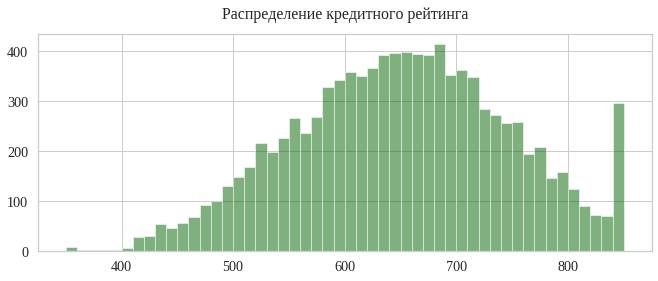

In [11]:
# Проверим на выбивающиеся значения по количественным данным
histogr(bank_dataset, 'score', title='Распределение кредитного рейтинга')

Распределение по кредитному рейтингу не показало артефактов. Есть некоторые значения низкого кредитного рейтинга, далее распределение похоже на нормальное и резкое повышение, почти 300 клиентов имеют максимальный кредитный рейтинг. 

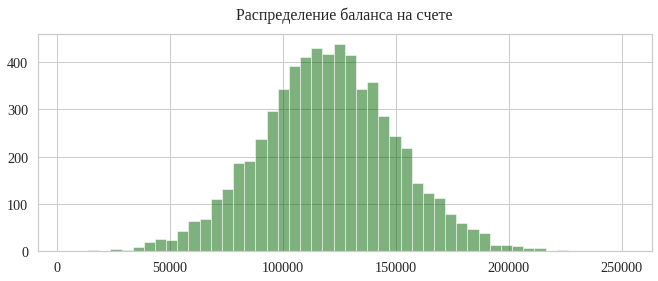

In [12]:
# Проверим на выбивающиеся значения по количественным данным
histogr(bank_dataset, 'balance', title='Распределение баланса на счете')

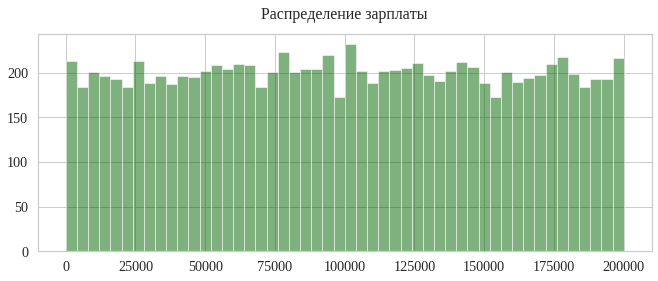

In [13]:
# Проверим на выбивающиеся значения по количественным данным
histogr(bank_dataset, 'estimated_salary', title='Распределение зарплаты')

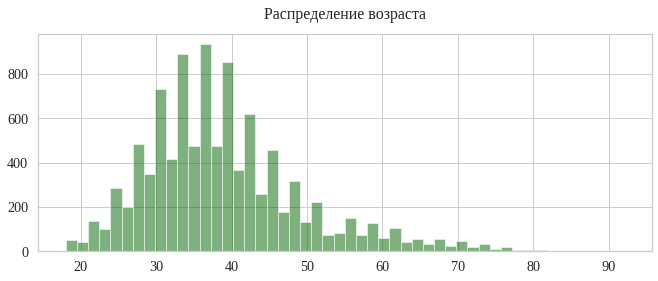

In [14]:
# Проверим на выбивающиеся значения по количественным данным
histogr(bank_dataset, 'age', title='Распределение возраста')

Распределение баланса похоже на нормальное, распределение зарплаты равомерное.

Возраст клиентов распределен нормально со смещением вправо.
Проверим категориальные данные на выбивающиеся значения.

In [15]:
# Города
bank_dataset['city'].value_counts()

Ярославль         5014
Ростов Великий    2509
Рыбинск           2477
Name: city, dtype: int64

In [16]:
# Пол
bank_dataset['gender'].value_counts()

М    5457
Ж    4543
Name: gender, dtype: int64

По типам городов и типу пола нет неожиданных значений. В Ярославле примерно половина всех клиентов, по Рыбинску и Ростову Великому количество клиентов примерно одинаково. Мужчин 55%, женщин 45%.

In [17]:
# Количество объектов
bank_dataset['objects'].value_counts()

2     1048
1     1035
7     1028
8     1025
5     1012
3     1009
4      989
9      984
6      967
10     490
0      413
Name: objects, dtype: int64

In [18]:
# Количество продуктов
bank_dataset['products'].value_counts()

1    5084
2    4590
3     266
4      60
Name: products, dtype: int64

Количество объектов в собственности варьируется от 0 до 10 и распределено примерно одинаково, за исключением крайних значений 0 и 10, по которым количество клиентов примерно в 2 раза ниже. Количество используемых банковских продуктов: от 1 до 4, наибольшее число клиентов пользуется одним продуктом.

In [19]:
# Значения кред.карты
bank_dataset['credit_card'].value_counts()

1    7055
0    2945
Name: credit_card, dtype: int64

In [20]:
# Значения активности
bank_dataset['loyalty'].value_counts()

1    5151
0    4849
Name: loyalty, dtype: int64

In [21]:
# Значения оттока
bank_dataset['churn'].value_counts()

0    7963
1    2037
Name: churn, dtype: int64

В последних приведенных данных нет значений, отличных от 1 и 0, значит, дополнительная обработка не нужна.

70% клиентов имеют кредитные карты, примерно 52% клиентов активны, к ушедшим клиентам относятся 20% датасета.


### Вывод

Данные и библиотеки загружены, проведена предварительная обработка, названия колонок скорректированы. Данные проверены на дубликаты, их не обнаружено. Тип данных подходит для исследования. Данные проверены на артефакты и выбвающиеся значения, отсутствующих признаков нет, по бинарным признакам значения 1 и 0, как и ожидалось.

Примерно половина клиентов из Ярославля, по четверти — из Рыбинска и Ростова Великого. 

Мужчин в датасете 55%, женщин 45%. 

Примерно половина клиентов использует 1 продукт. Ушедших клиентов в датасете около 20%. Примерно 70 % используют кредитную карту.

Данные по количеству объектов в собственности и зарплате распределены достаточно равномерно.

### Исследовательский анализ данных

Исследование данных позволит сформулировать гипотезы относительно категоризации клиентов.

Изучим средние значения и стандартные отклонения признаков в двух группах — тех, кто ушел в отток и тех, кто остался.

In [22]:
# Воспользуемся группировкой по значеню churn
bank_churn = bank_dataset.groupby('churn')
bank_churn.mean().round(2)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary
churn,,,,,,,,,
0,15733903.88,651.85,37.41,5.03,119535.86,1.54,0.71,0.55,99738.39
1,15732787.96,645.35,44.84,4.93,120746.97,1.48,0.70,0.36,101465.68


Ушедшие и оставшиеся клиенты имеют примерно одинаковые средние показатели по кредитному рейтингу (на 6.5 пунктов ниже у ушедших), по наличию кредитной карты, количеству используемых продуктов и балансу. Показательна разница loyalty (активный клиент или нет), **значения loyalty ниже у ушедших клиентов. Средний возраст ушедших клиентов выше: 45 против 37 лет**.


Изучим распределение для каждого количества продуктов для ушедших и оставшихся.

### Распределение рейтинга.

In [23]:
# Напишем функцию для графика типа violin для
def violin(y_name, title = "", y_label=""):
    """Функция, строящая график violin.
    Функция принимает на вход колонку, заголовок, название оси y,
    выводит violin.
    """
    plt.figure(figsize=(12, 8))
    ax = sns.violinplot(x='products', y=y_name, hue='churn', data=bank_dataset, split=True)
    labels = ax.get_xticklabels()
    ax.set_title(title, fontsize=18, pad = 15)
    ax.set_ylabel(y_label)
    ax.set_xlabel("Количество используемых продуктов")
    ax.set_xticklabels(labels)
    plt.show()

In [24]:
#Напишем функцию, строящую графики типа distplot
#название столбца, заголовок графика
def hist_2_(data1, data2, column, title = "", label1="", label2=""):
    """Функция, строящая график violin.
    Функция принимает на вход колонку, заголовок, название оси y,
    выводит violin.
    """
    plt.figure(figsize=(10, 7))
    ax = sns.distplot(data1[column],  bins=50, label=label1, kde=True)
    sns.distplot(data2[column], bins=50, label=label2, kde=True)
    plt.axes().set_title(title, fontsize=18, pad = 15)  
    plt.legend()
    plt.show()

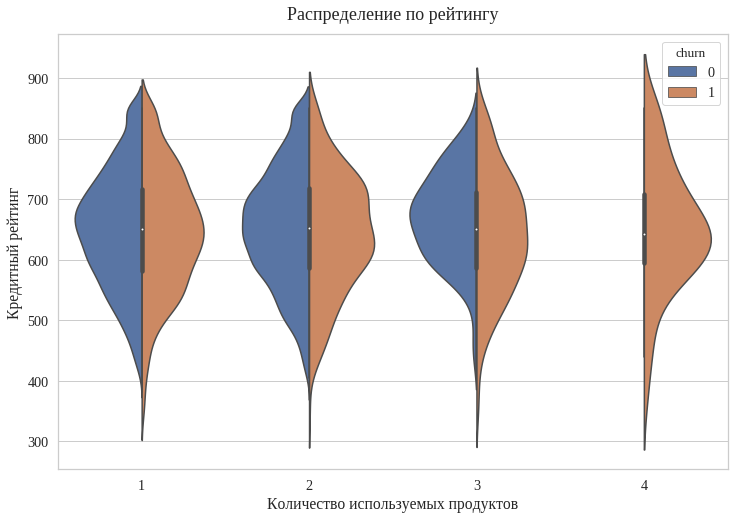

In [25]:
# Построим график типа violin для распределения по количеству используемых продуктов и рейтингу
violin('score', 
       "Распределение по рейтингу", 
       "Кредитный рейтинг")

График показал любопытную особенность: большинство клиентов, использующих 4 банковских продукта, ушло. Посмотрим точнее, остались ли клиенты, использующие 4 банковских продукта. Распределение по рейтингу похоже на нормальное, выраженных отличий нет для разных групп.

In [26]:
# Воспользуемся группировкой по продуктам
bank_products = bank_dataset.groupby('products').mean().round(2)
bank_products[['age', 'loyalty', 'churn']]

,age,loyalty,churn
products,,,
1,39.67,0.50,0.28
2,37.75,0.53,0.08
3,43.20,0.42,0.83
4,45.68,0.48,1.00


**Нет клиентов, которые использовали 4 продукта и остались**. Для клиентов, использующих 3 продукта, показатель оттока 0.83 что тоже высокий показатель. Показатели же активности примерно одинаковы для всех групп.

Изучим показатели кредитного рейтинга подробнее. Выберем оставшихся активных клиентов с кредитным рейтингом выше 80 процентиля, посчитаем их средний доход, возраст, другие показатели, сравним с клиентами ниже 20 процентиля по аналогичным показателям.

In [27]:
# Первые 20% клиентов с наивысшим кредитным рейтингом
bank_score80 = bank_dataset.query('loyalty == 1').sort_values(by='score', ascending = False).iloc[0:round(len(bank_dataset.query('loyalty == 1'))/5)]

In [28]:
# Последние 20% клиентов с низшим кредитным рейтингом
bank_score20 = bank_dataset.query('loyalty == 1').sort_values(by='score', ascending = False).iloc[round(len(bank_dataset.query('loyalty == 1'))*4/5):]

In [29]:
bank_score80.mean().round(2)

user_id             15733784.04
score                    786.85
age                       39.76
objects                    4.92
balance               120021.97
products                   1.55
credit_card                0.69
loyalty                    1.00
estimated_salary       99609.68
churn                      0.14
dtype: float64

In [30]:
bank_score20.mean().round(2)

user_id             15735771.88
score                    516.46
age                       39.61
objects                    4.88
balance               118346.20
products                   1.51
credit_card                0.69
loyalty                    1.00
estimated_salary       99062.29
churn                      0.16
dtype: float64

Средние очень похожи по всем показателям для клиентов, имеющих низкий и высокий кредитный рейтинг, вероятно, модель для кредитного скоринга была создана по другим данным, по этому датасету существенных отличий признаков нет.


### Распределение по городам

Посмотрим, какие показатели оттока по городам.

In [31]:
# Сводная таблица по городам и кол-ву продуктов, значения - отток
bank_gr_ch = bank_dataset.pivot_table(index = 'city', values='churn', aggfunc='mean' )
bank_gr_ch.round(2)

,churn
city,
Ростов Великий,0.32
Рыбинск,0.17
Ярославль,0.16


In [32]:
# Сводная таблица по городам и кол-ву продуктов, значения - показатель оттока
bank_gr = bank_dataset.pivot_table(index = 'city', columns = 'products', values='churn', aggfunc='mean' )
bank_gr.round(2)

products,1,2,3,4
city,,,,
Ростов Великий,0.43,0.12,0.90,1.0
Рыбинск,0.22,0.07,0.79,1.0
Ярославль,0.22,0.06,0.79,1.0


**В Ростове средний показатель оттока по любому кол-ву продуктов хуже, чем в соседних городах.**

Что с активностью клиентов? 

In [33]:
# Сводная таблица по городам и кол-ву продуктов, значения - активность
bank_gr = bank_dataset.pivot_table(index = 'city', columns = 'products', values='loyalty', aggfunc='mean' )
bank_gr.round(2)

products,1,2,3,4
city,,,,
Ростов Великий,0.47,0.55,0.43,0.42
Рыбинск,0.55,0.51,0.42,0.29
Ярославль,0.50,0.54,0.42,0.59


Активность клиентов по городам сопоставима. Для 4 продуктов в Рыбинске всего 7 клиентов, значение не показательно. Можно сказать, клиенты активны примерно одинаково.

In [34]:
# Города клиентов, использующих 4 продукта.
bank_products_4 = bank_dataset.query('products == 4')
bank_products_4['city'].value_counts()

Ярославль         29
Ростов Великий    24
Рыбинск            7
Name: city, dtype: int64

В Ростове достаточно много клиентов использовали 4 продукта, учитывая что количество клиентов из Ростова в датасете примерно в 2 раза меньше, чем в Ярославле.

### Распределение по балансу


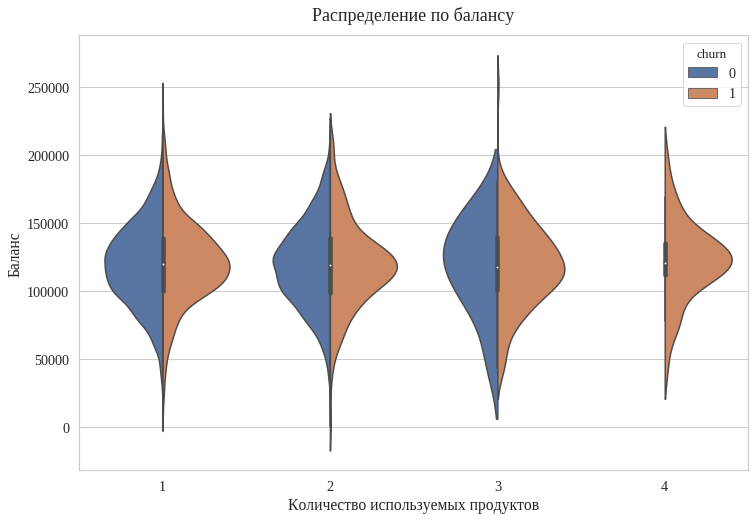

In [35]:
# Построим график типа violin для распределения по количеству используемых продуктов и балансу
violin('balance', 
       "Распределение по балансу", 
       "Баланс")

Распределение по балансу похоже на нормальное, выраженных отличий нет для разных групп.

Посмотрим на клиенов, кто не имеет баланса. Отличаются ли они от клиентов, у кого есть значения баланса?

In [36]:
# Датасет клиентов, кто не имеет баланса
bank_no_balance = bank_dataset[bank_dataset['balance'].isnull()]

In [37]:
# Датасет клиентов, кто имеет баланс
bank_balance = bank_dataset.copy()
bank_balance.dropna(subset=['balance'], inplace = True)

In [38]:
# Средние значения датасета без баланса
bank_no_balance.mean().round(1)

user_id             15734685.6
score                    649.5
age                       38.4
objects                    5.1
balance                    NaN
products                   1.8
credit_card                0.7
loyalty                    0.5
estimated_salary       98983.6
churn                      0.1
dtype: float64

In [39]:
# Средние значения датасета с балансом
bank_balance.mean().round(1)

user_id             15733104.8
score                    651.1
age                       39.2
objects                    5.0
balance               119827.5
products                   1.4
credit_card                0.7
loyalty                    0.5
estimated_salary      100717.4
churn                      0.2
dtype: float64

Клиенты, по которым не предоставлено значений баланса, имеют более низкий показатель оттока, 10% против 20% у остальных. Также эти клиенты используют, в среднем, меньше продуктов, чем остальные. Возможно, отсутствует данный показатель, тк у клиента ипотека и нет дебетового счета, либо предоставлен кредит наличными. Возможна также ошибка с выгрузкой.

### Показатели активности

Сопоставим активность с вероятностью ухода: разделим на 2 категории, активные и неактивные, для каждой категории посчитаем процент оттока.

In [40]:
# Воспользуемся группировкой по значеню loyalty
bank_loyalty = bank_dataset.groupby('loyalty')
bank_loyalty.mean().round(2)

,user_id,score,age,objects,balance,products,credit_card,estimated_salary,churn
loyalty,,,,,,,,,
0,15733553.13,647.97,38.00,5.10,120458.81,1.52,0.71,100767.20,0.27
1,15733792.77,652.93,39.79,4.93,119229.50,1.54,0.70,99452.97,0.14


**Для активных клиентов процент оттока составил 14%, для неактивных 27%.**
Остальные средние по признакам примерно одинаковы, средний рейтинг активных клиентов выше на 5 пунктов, в среднем, они старше на 2 года.

### Кредитные карты
Изучим наличие кредитных карт и сопоставим с вероятностью оттока: разделим на 2 категории, есть кредитные карты и нет кредитных карт, для каждой категории посчитаем процент оттока. 

In [41]:
# Воспользуемся группировкой по значеню credit_card
bank_credit_card = bank_dataset.groupby('credit_card')
bank_credit_card.mean().round(2)

,user_id,score,age,objects,balance,products,loyalty,estimated_salary,churn
credit_card,,,,,,,,,
0,15735238.06,651.35,39.11,4.91,119519.12,1.53,0.52,100974.40,0.21
1,15733024.75,650.19,38.84,5.05,119960.16,1.53,0.51,99721.16,0.20


Распределение рейтинга, баланса, возраста, кол-ва объектов и продуктов примерно одинаковое. Отток примерно одинаков для обиех категорий. Средняя зарплата незначительно (на 1 тыс. руб.) выше у тех, у кого нет кредитной карты.

### Распределение по зарплате

На этапе предварительного анализа данных распределение по зарплате было достаточно равномерным. Проверим, нет ли по категориям клиентов с различной зарплатой существенных отличий по другим показателям.

Разделим клиентов на категории по зарплате.

In [42]:
def salary(row):
    """Функция, категоризирующая клиентов по зарплате.
    Функция принимает на вход колонку зарплаты,
    выводит категорию.
    """
    if (row['estimated_salary'] >= 50000 and row['estimated_salary'] <= 100000):
        return 'от 50 до 100 тыс.'
    if (row['estimated_salary'] > 100000 and row['estimated_salary'] <= 150000):
        return 'от 100 до 150 тыс.'
    if row['estimated_salary'] > 150000:
        return 'более 150 тыс.'
    else:
        return 'до 50 тыс.'

In [43]:
# Добавляем категорию зарплаты
bank_dataset['salary_category'] = bank_dataset.apply(salary, axis = 1)
bank_dataset.head(5)

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,от 100 до 150 тыс.
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,от 100 до 150 тыс.
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,от 100 до 150 тыс.
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,от 50 до 100 тыс.
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,от 50 до 100 тыс.


In [44]:
# Воспользуемся группировкой по значеню bank_salary_category
bank_salary_category = bank_dataset.groupby('salary_category')
bank_salary_category.mean().round(2)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
salary_category,,,,,,,,,,
более 150 тыс.,15735519.02,651.99,38.76,5.02,119846.90,1.54,0.70,0.51,175443.73,0.21
до 50 тыс.,15731520.01,652.67,38.87,4.98,120078.34,1.52,0.71,0.52,24926.07,0.20
от 100 до 150 тыс.,15733120.42,648.16,38.78,5.04,119727.87,1.53,0.70,0.52,124900.25,0.20
от 50 до 100 тыс.,15734538.93,649.42,39.27,5.01,119671.29,1.53,0.71,0.52,74861.75,0.20


Показатели у всех категорий клиентов примерно одинаковые, разбивка по зарплате не особенно информативна.

### Распределение по возрасту

Разделим клиентов на категории по возрасту.

In [45]:
def age_categ(row):
    """Функция, категоризирующая клиентов по возрасту.
    Функция принимает на вход колонку age,
    выводит категорию возраста.
    """
    if (row['age'] >= 30 and row['age'] <= 40):
        return 'от 30 до 40 лет'
    if (row['age'] > 40 and row['age'] <= 60):
        return 'от 40 до 60 лет'
    if row['age'] > 60:
        return 'более 60 лет'
    else:
        return 'до 30 лет'

In [46]:
# Добавляем категорию возраста
bank_dataset['age_category'] = bank_dataset.apply(age_categ, axis = 1)
bank_dataset

,user_id,score,city,gender,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn,salary_category,age_category
0,15677338,619,Ярославль,Ж,42,2,NaN,1,1,1,101348.88,1,от 100 до 150 тыс.,от 40 до 60 лет
1,15690047,608,Рыбинск,Ж,41,1,83807.86,1,0,1,112542.58,0,от 100 до 150 тыс.,от 40 до 60 лет
2,15662040,502,Ярославль,Ж,42,8,159660.80,3,1,0,113931.57,1,от 100 до 150 тыс.,от 40 до 60 лет
3,15744090,699,Ярославль,Ж,39,1,NaN,2,0,0,93826.63,0,от 50 до 100 тыс.,от 30 до 40 лет
4,15780624,850,Рыбинск,Ж,43,2,125510.82,1,1,1,79084.10,0,от 50 до 100 тыс.,от 40 до 60 лет
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15648965,771,Ярославль,М,39,5,NaN,2,1,0,96270.64,0,от 50 до 100 тыс.,от 30 до 40 лет
9996,15612628,516,Ярославль,М,35,10,57369.61,1,1,1,101699.77,0,от 100 до 150 тыс.,от 30 до 40 лет
9997,15627268,709,Ярославль,Ж,36,7,NaN,1,0,1,42085.58,1,до 50 тыс.,от 30 до 40 лет
9998,15725091,772,Ростов Великий,М,42,3,75075.31,2,1,0,92888.52,1,от 50 до 100 тыс.,от 40 до 60 лет


In [47]:
# Воспользуемся группировкой по значеню age_category
bank_age_category = bank_dataset.groupby('age_category')
bank_age_category.mean().round(2)

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
age_category,,,,,,,,,,
более 60 лет,15733672.72,654.55,67.51,4.91,118331.87,1.51,0.71,0.81,98126.18,0.25
до 30 лет,15732070.47,651.14,25.93,5.10,121181.96,1.56,0.71,0.51,100855.25,0.08
от 30 до 40 лет,15733908.78,651.40,35.18,5.01,119686.12,1.54,0.71,0.50,99558.38,0.12
от 40 до 60 лет,15734166.74,648.27,47.24,4.99,119595.78,1.51,0.69,0.50,100795.13,0.40


Интересно, что клиенты старше 60 лет, вероятно, получающие пенсию в банке, показывают самую высокую активность 81% и процент оттока 25%. Клиента от 40 до 60 лет имеют самый высокий процент оттока - 40%. Наименьший процент оттока у клиентов до 30 лет. Показатели кредитного скоринга выше у клиентов старше 60 лет.

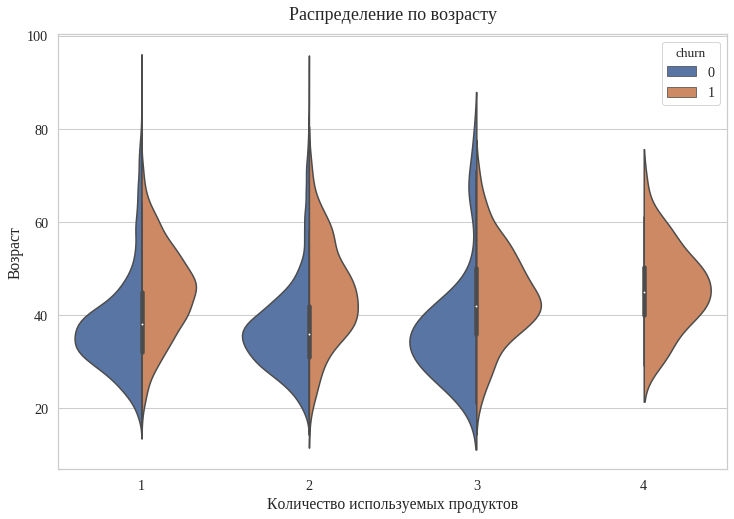

In [48]:
# Построим график типа violin для распределения по количеству используемых продуктов и возрасту
violin('age', 
       "Распределение по возрасту", 
       "Возраст")

Видно, что оставшиеся клиенты, в среднем, моложе ушедших. Для клиентов, использующих 3 продукта, есть небольшое увеличение кол-ва клиентов после 60 лет, вероятно, получающих пенсию в банке. Клиенты, использующие 4 продукта, все ушли в отток.

### Вывод

Нет клиентов, которые использовали 4 продукта и остались. Для клиентов, использующих 3 продукта, показатель оттока 0.83 —  высокий показатель. 

Причина, по которой все клиенты, использующие 4 продукта, ушли, требует дополнительного выяснения. Возможно, клиенты, использующие более двух продуктов, ушли после закрытия кредитов, возможно, другой банк предложил более привлекательные ставки, что привело к рефинансированию и закрытию счетов.  Подобные клиенты живут в разных городах и имеют разброс по возрасту, зарплате и прочему, очевидного сходства нет. 

Для активных клиентов (loyalty = 1) процент оттока составил 14%, для неактивных 27%, если активность клиента падает, большая вероятность, что он уйдет.

В Ростове средний показатель оттока по любому кол-ву продуктов почти в 2 раза выше, чем в соседних городах, причины этого требуют дальнейшего уточнения.

Клиенты, по которым не предоставлено значений баланса, имеют более низкий показатель оттока, 10% против 20% у остальных. Также эти клиенты используют, в среднем, меньше продуктов, чем остальные. Возможно, отсутствует данный показатель, тк у клиента ипотека и нет дебетового счета, либо предоставлен кредит наличными. Возможна также ошибка с выгрузкой. 

Интересно, что клиенты старше 60 лет, вероятно, получающие пенсию в банке, показывают самую высокую активность 81% и процент оттока — 25%. Вероятно, самая высокая активность связана с ежемесячной выплатой пенсий. Клиенты от 40 до 60 лет имеют самый высокий процент оттока — 40%. Вероятно, некоторые из них прекратили получать зарплату в банке. Наименьший процент оттока у клиентов до 30 лет. Показатели кредитного скоринга выше у клиентов старше 60 лет.

Оставшиеся клиенты, в среднем, моложе ушедших. Средний возраст ушедших клиентов выше: 45 против 37 лет.

## Проверка статистических гипотез

Проверим следующие гипотезы: 

•	Доход клиентов, которые пользуются двумя продуктами банка и клиентов, которые пользуются одним продуктом, отличаются;

•	Доли оттока клиентов из Рыбинска и Ярославля отличаются;

Решаем вопрос о принятии или отвержении нулевой гипотезы по p-value, как вероятность ошибки при отклонении нулевой гипотезы. То есть, чем выше p-value тем скорее отклонение нулевой гипотезы будет ошибочным. Критический уровень статистической значимости примем за 5%, что означает, что мы допускаем 5% вероятность ошибки в полученном результате.
При значениях p-value менее 0,05 следует признать, что можем отвергнуть нулевую гипотезу.

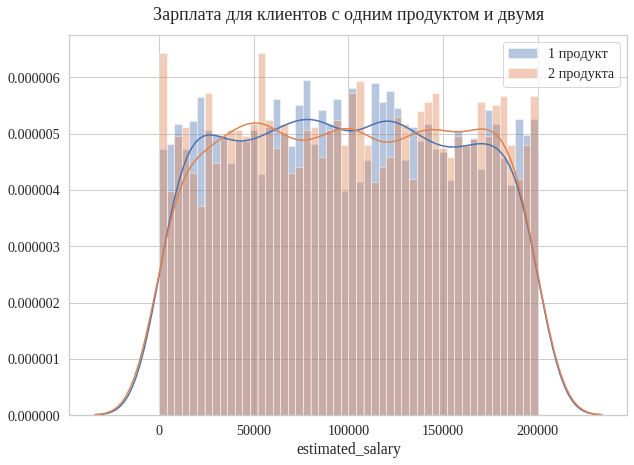

In [49]:
# Гистограмма распределения дохода клиентов для тех, кто пользуется одним продуктом и двумя
hist_2_(bank_dataset.query('products == 1'), 
        bank_dataset.query('products == 2'), 
        'estimated_salary', 
        title = "Зарплата для клиентов с одним продуктом и двумя", 
        label1="1 продукт", 
        label2="2 продукта")

Данные распределены не нормально, распределение равномерное.
Поэтому проверим гипотезы о схожести распределения выборок, применяя U-критерий Манна-Уитни.

**Нулевая гипотеза:** 
Распределение зарплат клиентов, использующих 1 продукт, соответствует распределению зарплат клиентов, использующих 2 продукта.

**Альтернативная гипотеза:**  Распределение зарплат клиентов, использующих 1 продукт, не соответствует распределению зарплат клиентов, использующих 2 продукта.

In [50]:
alpha = 0.05  # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу

results = st.mannwhitneyu(bank_dataset.query('products == 1')['estimated_salary'], 
                       bank_dataset.query('products == 2')['estimated_salary'])

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу: разница статистически значима')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.20397833259638254
Не получилось отвергнуть нулевую гипотезу


Нет оснований отвергать нулевую гипотезу, что распределение зарплат клиентов, использующих 1 продукт соответствует распределению зарплат клиентов, использующих 2 продукта.

**Нулевая гипотеза:** Доля оттока клиентов из Рыбинска равна доле оттока из Ярославля.

**Альтернативная гипотеза:**  Доля оттока клиентов из Рыбинска не равна доле оттока из Ярославля.

Сравним доли клиентов, ушедших в отток по городам.

Предварительно посмотрим на сводную таблицу оттока по городам.

In [51]:
# Сводная таблица по городам и кол-ву продуктов, значения - отток
bank_gr_ch = bank_dataset.pivot_table(index = 'city', values='churn', aggfunc='mean' )
bank_gr_ch.round(2)

,churn
city,
Ростов Великий,0.32
Рыбинск,0.17
Ярославль,0.16


Значения оттока по Рыбинску и Ярославлю похожи. Проверим, такая разница в пропорциях достаточна ли, чтобы говорить о статистически значимом различии. 

In [52]:
alpha = 0.05  # критический уровень статистической значимости

# пропорция оттока в Ростове:
p1 = bank_dataset.query('city == "Ярославль"')['churn'].mean()
# пропорция оттока в Рыбинске:
p2 = bank_dataset.query('city == "Рыбинск"')['churn'].mean()

# пропорция оттока в комбинированном датасете:
p_combined = len(bank_dataset.query('city != "Ростов Великий" & churn == 1')['churn'])/len(bank_dataset.query('city != "Ростов Великий"')['churn'])
# разница пропорций в датасетах
difference = p1 - p2 

# считаем статистику в ст.отклонениях стандартного нормального распределения
z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/len(bank_dataset.query('city == "Рыбинск"')['churn']) + 1/len(bank_dataset.query('city == "Ярославль"')['churn'])))

# задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
distr = st.norm(0, 1)
# считаем p_value
p_value = (1 - distr.cdf(abs(z_value))) * 2
print('p-значение: ', p_value)
if p_value < alpha:
    print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
else:
    print( 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными' )

p-значение:  0.5677610235238439
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Разница между процентами оттока 0,16 и 0,17 не оказалась статистически значимой. Нет оснований считать, что доли оттока в городах существенно отличаются.

### Вывод

Результаты статистических тестов не противоречат гипотезе, что доли оттока в городах Ярославль и Рыбинск одинаковы.

Нельзя отвергнуть гипотезу, что распределение зарплаты клиентов, которые пользуются одним продуктами банка равно распределению  зарплаты клиентов, которые пользуются двумя продуктами банка.

## Модель прогнозирования оттока пользователей

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя.
Для начала построим матрицу корреляций.

In [53]:
cm = bank_dataset.corr()
cm

,user_id,score,age,objects,balance,products,credit_card,loyalty,estimated_salary,churn
user_id,1.000000,0.005308,0.009497,-0.014883,-0.008690,0.016972,-0.014025,0.001665,0.015271,-0.006248
score,0.005308,1.000000,-0.003965,0.000842,-0.004744,0.012238,-0.005458,0.025651,-0.001384,-0.027094
age,0.009497,-0.003965,1.000000,-0.009997,-0.012822,-0.030680,-0.011721,0.085472,-0.007201,0.285323
objects,-0.014883,0.000842,-0.009997,1.000000,0.005827,0.013444,0.022583,-0.028362,0.007784,-0.014001
balance,-0.008690,-0.004744,-0.012822,0.005827,1.000000,-0.001027,0.006721,-0.020418,-0.001856,0.017208
products,0.016972,0.012238,-0.030680,0.013444,-0.001027,1.000000,0.003183,0.009612,0.014204,-0.047820
credit_card,-0.014025,-0.005458,-0.011721,0.022583,0.006721,0.003183,1.000000,-0.011866,-0.009933,-0.007138
loyalty,0.001665,0.025651,0.085472,-0.028362,-0.020418,0.009612,-0.011866,1.000000,-0.011421,-0.156128
estimated_salary,0.015271,-0.001384,-0.007201,0.007784,-0.001856,0.014204,-0.009933,-0.011421,1.000000,0.012097
churn,-0.006248,-0.027094,0.285323,-0.014001,0.017208,-0.047820,-0.007138,-0.156128,0.012097,1.000000


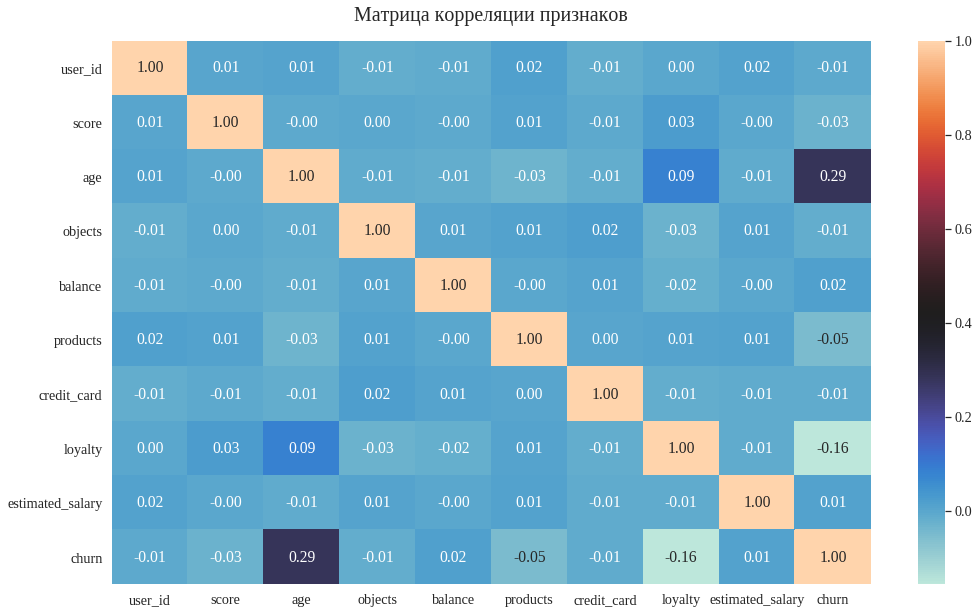

In [54]:
# Тепловая карта  
plt.figure(figsize=(17, 10))
ax = sns.heatmap(cm, annot=True, fmt='.2f', cmap= "icefire")
ax.set_title('Матрица корреляции признаков', fontsize = 20, pad=20)
ax.set_ylabel('')
ax.set_xlabel('')
plt.show()

Нет сильной корреляции признаков, нет необходимости убирать признаки.

In [55]:
bank_model = bank_dataset.copy()

In [56]:
bank_model = bank_model.drop(['salary_category', 'age_category', 'gender', 'city', 'balance'], axis = 1)

In [57]:
# посмотрим, как соотносятся классы набора данных
print('Соотношение классов:\n', bank_model['churn'].value_counts())

Соотношение классов:
 0    7963
1    2037
Name: churn, dtype: int64


In [58]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = bank_model.drop('churn', axis=1)
y = bank_model['churn']

In [59]:
# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [60]:
# Стандартизируем данные
sc = StandardScaler()
#обучаем scaler и одновременно трансформируем матрицу для обучающей выборки
X_train_st = sc.fit_transform(X_train)  
#применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = sc.transform(X_test) #ваш код здесь

In [61]:
# функция описания метрик 
def metrics_1(y_test, y_pred):
    """Функция, выводящая метрики оценки модели.
    Функция принимает на входy_test, y_pred,
    выводит значения метрик.
    """
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, y_pred)))
    print('Precision: {:.2f}'.format(precision_score(y_test, y_pred)))
    print('Recall: {:.2f}'.format(recall_score(y_test, y_pred)))

Мы решаем задачу бинарной классификации и самой важной метрикой можем признать precision - точность предсказания. Для решения задач бинарной классификации можно использовать несколько алгоритмов, проверим по метрикам, какой из них дает наиболее точные предсказания. 

In [62]:
# RandomForestClassifier
model = RandomForestClassifier(random_state=0)
model.fit(X_train_st, y_train)
y_pred = model.predict(X_test_st)
threshold = 0.5
y_pred = [0 if i < threshold else 1 for i in y_pred]
print('Метрики при использовании RandomForestClassifier:')
metrics_1(y_test, y_pred)

Метрики при использовании RandomForestClassifier:
Accuracy: 0.85
Precision: 0.70
Recall: 0.41


In [63]:
# LogisticRegression
model = LogisticRegression(random_state=0)
model.fit(X_train_st, y_train)
y_pred = model.predict(X_test_st)
print('Метрики при использовании LogisticRegression:')
metrics_1(y_test, y_pred)

Метрики при использовании LogisticRegression:
Accuracy: 0.80
Precision: 0.56
Recall: 0.13


In [64]:
# DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=0)
model.fit(X_train_st, y_train)
y_pred = model.predict(X_test_st)
print('Метрики при использовании DecisionTreeClassifier:')
metrics_1(y_test, y_pred)

Метрики при использовании DecisionTreeClassifier:
Accuracy: 0.78
Precision: 0.46
Recall: 0.49


In [65]:
# GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100, random_state = 0) 
model.fit(X_train_st, y_train)
y_pred = model.predict(X_test_st)
print('Метрики при использовании GradientBoostingClassifier:')
metrics_1(y_test, y_pred)

Метрики при использовании GradientBoostingClassifier:
Accuracy: 0.86
Precision: 0.75
Recall: 0.46


Наилучшие показатели точности у GradientBoostingClassifier. Оценим важность признаков.

In [66]:
# Важность признаков
importances =  pd.DataFrame([model.feature_importances_])
importances.columns = bank_model.columns[:8]
importances = importances.T.sort_values(by=0, ascending = False)
importances.style.format({(0):'{:.2f}'})

,0
age,0.45
products,0.34
loyalty,0.13
user_id,0.03
score,0.03
estimated_salary,0.03
objects,0.01
credit_card,0.00


Коэффициенты важности признаков показывают, что самым важным признаком является возраст клиентов, далее идет кол-во применяемых продуктов и на третьем месте активность клиентов.

### Вывод

Наилучшие показатели точности у GradientBoostingClassifier с коэффициентом точности Precision = 0,75. 

Надо отметить, что данные, предоставленные для работы, содержали довольно равномерное распредение зарплаты и количества объектов, вероятно, являясь выборкой по определенным показателям. Результаты обучения модели с более полным датасетом могли отличаться. 

По предоставленным данным, коэффициенты важности признаков показывают, что самым важным признаком является возраст клиентов, далее идет кол-во применяемых продуктов и на третьем месте активность клиентов. Результаты работы модели подтверждают данные, полученный на первом этапе исследования, а именно, что самыми важными для показателя оттока можно считать возраст, количество используемых продуктов и активность клиента.

## Вывод

Проанализированы данные о клиентах регионального банка.
Существенная предобработка данных не потребовалась. 

По представленному датасету:
- примерно половина клиентов — из Ярославля, по четверти — из Рыбинска и Ростова Великого;
- мужчин в датасете 55%, женщин 45%;
- примерно 70% используют кредитную карту;
- примерно половина клиентов использует только 1 продукт;
- ушедших клиентов в датасете около 20%.  

Были проверены 2 статистические гипотезы. Результаты статистических тестов не противоречат гипотезам, что доли оттока в городах Ярославль и Рыбинск одинаковы, и что распределение дохода клиентов, которые пользуются одним продуктами банка равно распределению доходов клиентов, которые пользуются двумя продуктами банка.


На основе данных построена модель бинарной классификации клиентов, где целевой признак — факт оттока клиента. Проработаны несколько моделей, GradientBoostingClassifier показала наибольшую точность (Precision = 0.75), принята для дальнейшей работы. Надо отметить, что данные содержали довольно равномерное распредение зарплаты и количества объектов, вероятно, являясь выборкой по определенным показателям. Результаты обучения модели с более полным датасетом могут быть более точными. 

По результату работы модели, коэффициенты важности признаков показывают, что самым важным признаком является возраст клиентов, далее идет кол-во применяемых продуктов и на третьем месте активность клиентов, что подтверждает результаты исследовательского анализа данных.

По результатам исследования:

- нет клиентов, которые использовали 4 продукта и остались;
- для клиентов, использующих 3 продукта, показатель оттока высок — 83%;
- для активных клиентов процент оттока составил 14%, для неактивных — 27%;
- в Ростове средний показатель оттока по любому кол-ву продуктов почти в 2 раза выше, чем в соседних городах;
- клиенты старше 60 лет, вероятно, получающие пенсию в банке, показывают самую высокую активность 81% и процент оттока — 25%. У них также самые высокие показатели кредитного скоринга;
- клиенты от 40 до 60 лет имеют самый высокий процент оттока — 40%. Средний возраст ушедших клиентов 45 лет;
- наименьший процент оттока у клиентов до 30 лет;

**Рекомендации:**

- Причина, по которой все клиенты, использующие четыре продукта, ушли, требует дополнительного выяснения. Возможно, клиенты, использующие более двух продуктов, ушли после закрытия кредитов, возможно, другой банк предложил более привлекательные ставки, что привело к рефинансированию и закрытию счетов. 

- Наименьший показатель оттока у клиентов, использующих два продукта и до 30 лет. Поэтому, если такой клиент использует 1 продукт, например, дебетовый счет, можно рекомендовать дополнительный продукт, например, зарплатный счет или инвестиционный продукт. Они могут удержать клиента в долгосрочной перспективе. Для клиентов, использующих два продукта, рекомендации по дополнительным следует проводить только после выяснения причин оттока клиентов с тремя и более продуктами.

- Если активность клиента падает, есть больший риск, что он уйдет. Поэтому при снижении показателя активности в 2 раза следует обратить на клиента дополнительное внимание, предложить выгодные условия.

- По клиентам старше 60 лет, вероятно, самая высокая активность связана с ежемесячной выплатой пенсий. Самый высокий процент оттока у клиентов от 40 до 60 лет, вероятно, некоторые из них прекратили получать зарплату в банке. Для клиентов, завершающих зарплатный проект, стоит рекомендовать пенсионный. Зарплатный или пенсионный проект могут удержать клиентов в долгосрочной перспективе.

- В Ростове средний показатель оттока по любому кол-ву продуктов почти в 2 раза выше, чем в соседних городах, причины этого требуют дальнейшего выяснения, усиленного контроля сервиса.

**Презентация:**

https://drive.google.com/file/d/1wYKWLcj2bQ-3UfivpdpnSez8sR3ECcFT/view?usp=sharing

**Дашборд:**

Дашборд отображает распределение заработной платы клиентов.
Цветом показан процент клиентов, имеющих кредитную карту.
Фильтр дашборда позволяет сделать выборку по ушедшим и оставшимся клиентам.

https://public.tableau.com/views/Segmentationofbankusers/Dashboard1?:language=en-US&publish=yes&:display_count=n&:origin=viz_share_link